# Building A CNN for Binary Classification of Custom Images

Importing relevant packages, some for image pre-processing 

In [50]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models # add models to the list
from torchvision.utils import make_grid
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [51]:
import os
from PIL import Image
from IPython.display import display

import warnings
warnings.filterwarnings("ignore")

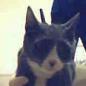

In [52]:
# TESTING
with Image.open('../Data/CATS_DOGS/CATS_DOGS//test/CAT/10107.jpg') as im:
    display(im)

Creating a list of image file names

In [29]:
path = '..\\Data\\CATS_DOGS\\'
img_names = []

for folder, subfolders, filenames in os.walk(path):
    for img in filenames:
        img_names.append(folder+'\\'+img)
        
print('Images: ',len(img_names))

Images:  24994


In [30]:
# Creating a list
img_sizes = []
rejected = []

for item in img_names:
    try:
        with Image.open(item) as img:
            img_sizes.append(img.size)
    except:
        rejected.append(item)
        
print(f'Images:  {len(img_sizes)}')
print(f'Rejects: {len(rejected)}')

Images:  24994
Rejects: 0


Checking Summary statistics on image height and width 

In [31]:
# Convert the list to a DataFrame
df = pd.DataFrame(img_sizes)

# Run summary statistics on image widths
df[0].describe()

count    24994.000000
mean       404.493518
std        108.941802
min         42.000000
25%        323.000000
50%        448.000000
75%        500.000000
max        500.000000
Name: 0, dtype: float64

In [32]:
# Run summary statistics on image heights
df[1].describe()

count    24994.000000
mean       361.037129
std         96.936811
min         33.000000
25%        302.000000
50%        375.000000
75%        421.000000
max        500.000000
Name: 1, dtype: float64

The shortest width is 42, the shortest height is 33, the largest width and height are 500, and that most images have more than 300 pixels per side.

# Before building the CNN, pre-process training images by creating transformations of the images to see their effect.

(500, 387)


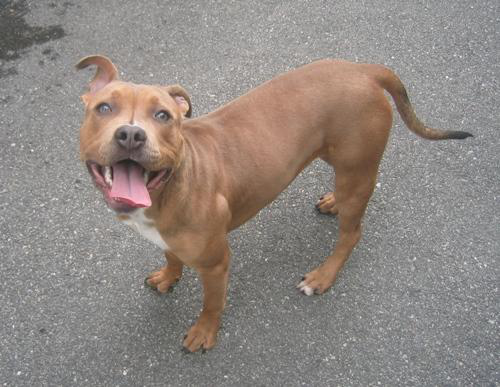

In [33]:
dog = Image.open('..\\Data\\CATS_DOGS\\CATS_DOGS\\train\\DOG\\14.jpg')
print(dog.size)
display(dog)

In [34]:
r, g, b = dog.getpixel((0, 0))
print(r,g,b)

90 95 98


torch.Size([3, 387, 500])


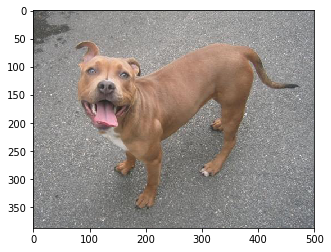

In [35]:
transform = transforms.Compose([
    transforms.ToTensor()
])
im = transform(dog)
print(im.shape)
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

torch.Size([3, 224, 289])


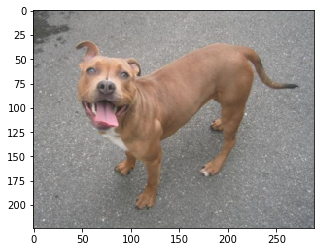

In [36]:
transform = transforms.Compose([
    transforms.Resize(224), # call this a list of transformations to resize the images
    transforms.ToTensor()
])
im = transform(dog)
print(im.shape)
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

(135, 102)


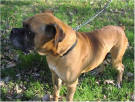

In [37]:
small_dog = Image.open('../Data/CATS_DOGS/CATS_DOGS/train/DOG/11.jpg')
print(small_dog.size)
display(small_dog)

torch.Size([3, 224, 296])


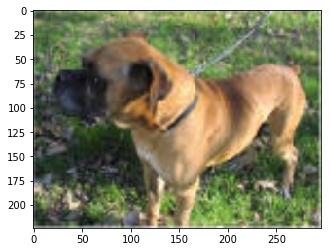

In [38]:
im = transform(small_dog)
print(im.shape)
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

torch.Size([3, 224, 224])


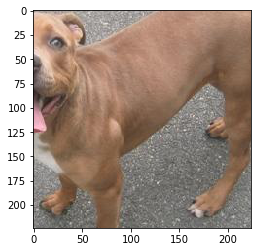

In [39]:
transform = transforms.Compose([
    transforms.CenterCrop(224), 
    transforms.ToTensor()
])
im = transform(dog) # this crops the original image
print(im.shape)
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

torch.Size([3, 224, 224])


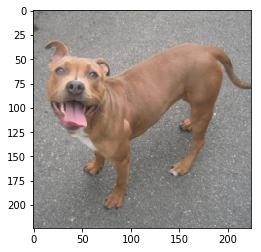

In [40]:
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224), 
    transforms.ToTensor()
])
im = transform(dog)
print(im.shape)
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

torch.Size([3, 387, 500])


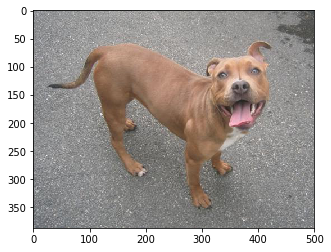

In [41]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=1),  # normally we'd set p=0.5
    transforms.ToTensor()
])
im = transform(dog)
print(im.shape)
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

torch.Size([3, 224, 224])


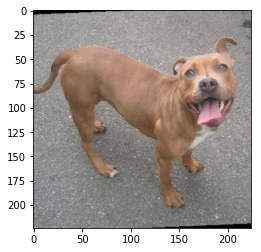

In [42]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=1),  # normally we'd set p=0.5
    transforms.RandomRotation(30),
    transforms.Resize(224),
    transforms.CenterCrop(224), 
    transforms.ToTensor()
])
im = transform(dog)
print(im.shape)
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

torch.Size([3, 387, 500])


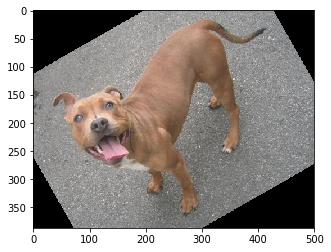

In [43]:
transform = transforms.Compose([
    transforms.RandomRotation(30),  # rotate randomly between +/- 30 degrees
    transforms.ToTensor()
])
im = transform(dog)
print(im.shape)
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

torch.Size([3, 224, 224])


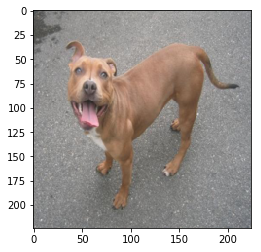

In [44]:
transform = transforms.Compose([
    transforms.Resize((224,224)),  # be sure to pass in a list or a tuple
    transforms.ToTensor()
])
im = transform(dog)
print(im.shape)
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

torch.Size([3, 387, 500])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


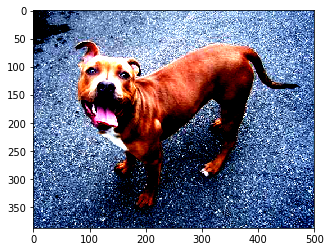

In [45]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])
im = transform(dog)
print(im.shape)
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

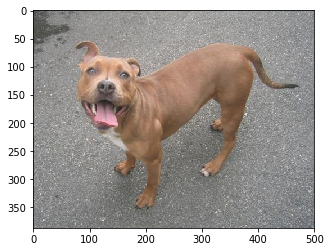

In [46]:
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)
im_inv = inv_normalize(im)
plt.figure(figsize=(12,4))
plt.imshow(np.transpose(im_inv.numpy(), (1, 2, 0)));

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


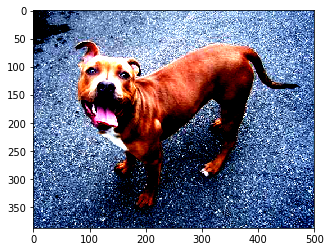

In [47]:
plt.figure(figsize=(12,4))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

Organizing the above transformations into train/test splits

In [55]:
train_transform = transforms.Compose([
        transforms.RandomRotation(10),      # rotate +/- 10 degrees
        transforms.RandomHorizontalFlip(),  # reverse 50% of images
        transforms.Resize(224),             # resize shortest side to 224 pixels
        transforms.CenterCrop(224),         # crop longest side to 224 pixels at center
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

test_transform = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

Using dataloader to load data into training and lesting sets

In [56]:
root = '../Data/CATS_DOGS/CATS_DOGS'

train_data = datasets.ImageFolder(os.path.join(root, 'train'), transform=train_transform)
test_data = datasets.ImageFolder(os.path.join(root, 'test'), transform=test_transform)

#ImageFolder is a build in torch dataset

torch.manual_seed(42)
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=True)

class_names = train_data.classes

print(class_names)
print(f'Training images available: {len(train_data)}')
print(f'Testing images available:  {len(test_data)}')

['CAT', 'DOG']
Training images available: 18743
Testing images available:  6251


Label: [1 1 1 0 1 0 1 1 0 0]
Class: DOG DOG DOG CAT DOG CAT DOG DOG CAT CAT


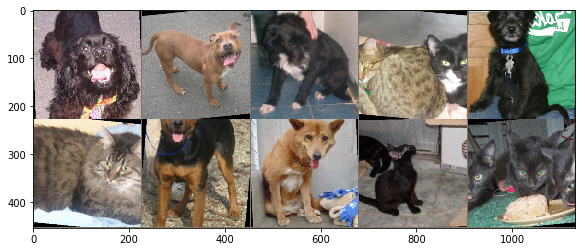

In [59]:
# first batch of 10 images
for images,labels in train_loader: 
    break

print('Label:', labels.numpy())
print('Class:', *np.array([class_names[i] for i in labels]))

im = make_grid(images, nrow=5)  

# normalize the images
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)
im_inv = inv_normalize(im)

# Print the images
plt.figure(figsize=(12,4))
plt.imshow(np.transpose(im_inv.numpy(), (1, 2, 0)));

# Defining the CNN

Defining the Convolutional Neural Network. There will be only 2 output channels since it is a binary classification. Then define the forward propogation.

In [64]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        self.fc1 = nn.Linear(54*54*16, 120) 
        #Since pixel width is 224, kernel and pooling layer results in (((224−2)/2)−2)/2=54.5
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        # 2*2 filter matrix and 2 is the stride
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 54*54*16)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

In [65]:
torch.manual_seed(101)
CNNmodel = ConvolutionalNetwork()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(CNNmodel.parameters(), lr=0.001)
CNNmodel

ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=46656, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
)

In [63]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>8}')
    print(f'________\n{sum(params):>8}')

# Training the CNNmodel

In the interests of time, we'll limit the number of training batches to 800, and the number of testing batches to 300. We'll train the model on 8000 of 18743 available images, and test it on 3000 out of 6251 images.

In [71]:
import time
start_time = time.time()

epochs = 3

max_trn_batch = 800
max_tst_batch = 300

train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        
        # Limit the number of batches
        if b == max_trn_batch:
            break
        b+=1
        
        # Apply the model
        y_pred = CNNmodel(X_train)
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print interim results
        if b%200 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/8000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')

    train_losses.append(loss)
    train_correct.append(trn_corr)

    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            # Limit the number of batches
            if b == max_tst_batch:
                break

            # Apply the model
            y_val = CNNmodel(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()

    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)

print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch:  0  batch:  200 [  2000/8000]  loss: 0.35231072  accuracy:  75.700%
epoch:  0  batch:  400 [  4000/8000]  loss: 0.53754246  accuracy:  76.400%
epoch:  0  batch:  600 [  6000/8000]  loss: 0.57665074  accuracy:  76.500%
epoch:  0  batch:  800 [  8000/8000]  loss: 0.29501498  accuracy:  76.500%
epoch:  1  batch:  200 [  2000/8000]  loss: 0.30956909  accuracy:  77.600%
epoch:  1  batch:  400 [  4000/8000]  loss: 0.44234571  accuracy:  77.450%
epoch:  1  batch:  600 [  6000/8000]  loss: 0.41509390  accuracy:  78.433%
epoch:  1  batch:  800 [  8000/8000]  loss: 0.59927225  accuracy:  78.013%
epoch:  2  batch:  200 [  2000/8000]  loss: 0.81525439  accuracy:  78.950%
epoch:  2  batch:  400 [  4000/8000]  loss: 0.50992125  accuracy:  78.650%
epoch:  2  batch:  600 [  6000/8000]  loss: 0.70932341  accuracy:  79.183%
epoch:  2  batch:  800 [  8000/8000]  loss: 0.57533872  accuracy:  79.112%

Duration: 1863 seconds


In [72]:
torch.save(CNNmodel.state_dict(), 'CustomImageCNNModel.pt')

# Visualizing the results

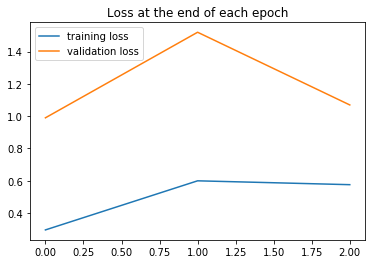

In [73]:
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

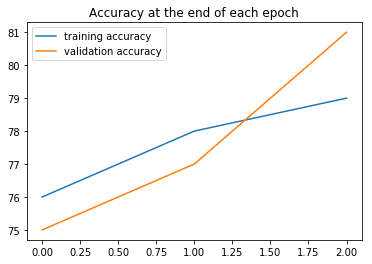

In [74]:
plt.plot([t/80 for t in train_correct], label='training accuracy')
plt.plot([t/30 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

In [75]:
print(test_correct)
print(f'Test accuracy: {test_correct[-1].item()*100/3000:.3f}%')

[tensor(2261), tensor(2316), tensor(2432)]
Test accuracy: 81.067%
